## 지그재그 로그 데이터분석 


6월 11일에 활동한 고객 정보, 쇼핑몰 정보, 거래 정보, 상품 정보, 그리고 고객의 행동 정보를 이해하고 분석하자.


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
os.chdir("C:\\Users\\hands\\Desktop\\DsSchool\\실전데이터분석\\02_transaction")

In [3]:
import matplotlib as mpl
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load Dataset

In [5]:
import sqlite3

In [6]:
connect = sqlite3.connect('../zigzag_DB.db')
query = "SELECT * FROM 'order'"
order = pd.read_sql(query,connect)

In [7]:
order.head()

,timestamp,user_id,goods_id,shop_id,price
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000
1,2018-06-11 00:02:33.763,smDmRnykg61KajpxXKzQ0oNkrh2nuSBj,1351,12,9500
2,2018-06-11 00:04:06.364,EyGjKYtSqZgqJ1ddKCtH5XwGirTyOH2P,646,14,22000
3,2018-06-11 00:04:17.258,KQBGi33Zxh5Dgu0WEkOkjN0YqTT_wxC3,5901,46,29800
4,2018-06-11 00:05:26.010,lq1Je3voA3a0MouSFba3629lKCvweI24,5572,89,29000


**1. order 테이블을 이용해 지그재그의 당일 매출 상위 10개 쇼핑몰을 구하자.**

In [8]:
table = pd.pivot_table(order, values = 'price', index = 'shop_id', aggfunc='sum')
table.sort_values('price',ascending=False).head(10)

,price
shop_id,
22,1365200
14,872000
63,710700
32,707900
126,669400
6,655900
11,653000
60,558300
19,518400


**2. 판매 건수를 포함하여 피벗테이블을 만들자. 또한, 상위 10개 쇼핑몰의 매출을 막대그래프로 보여주세요.**

In [9]:
table = pd.pivot_table(data = order,
                      values = 'price',
                      index = 'shop_id',
                      aggfunc = ['sum','count'])
table.columns = ['sum','count']
table = table.sort_values('count', ascending=False).head(10)
table

,sum,count
shop_id,,
22,1365200,99
12,446900,42
126,669400,39
32,707900,37
14,872000,30
63,710700,27
6,655900,24
60,558300,23
28,389270,20


In [10]:
table_sum_top10 = table.sort_values('sum',ascending=False).head(10)
table_count_top10 = table.sort_values('count', ascending=False).head(10)

sum_top10 = table_sum_top10.index
count_top10 = table_count_top10.index

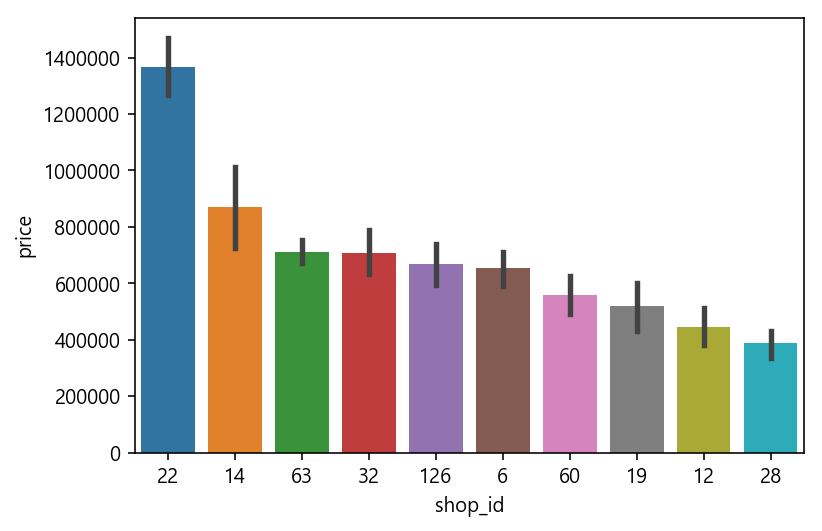

In [11]:
top_order = order[order['shop_id'].isin(sum_top10)]

sns.barplot(data=top_order, x = 'shop_id', y = 'price',
           estimator = sum, order = sum_top10)

**3. 시간대별 지그재그 매출을 구한 후 시각화하자.**

* 지그재그 이용자들의 구매 패턴을 파악할 수 있을것이다.

In [12]:
order.dtypes

timestamp    object
user_id      object
goods_id      int64
shop_id       int64
price         int64
dtype: object

In [13]:
#우선, timestamp의 데이터 타입을 datetime으로 바꾸자
order['timestamp'] = pd.to_datetime(order['timestamp'])

In [14]:
sns.set_style('whitegrid')

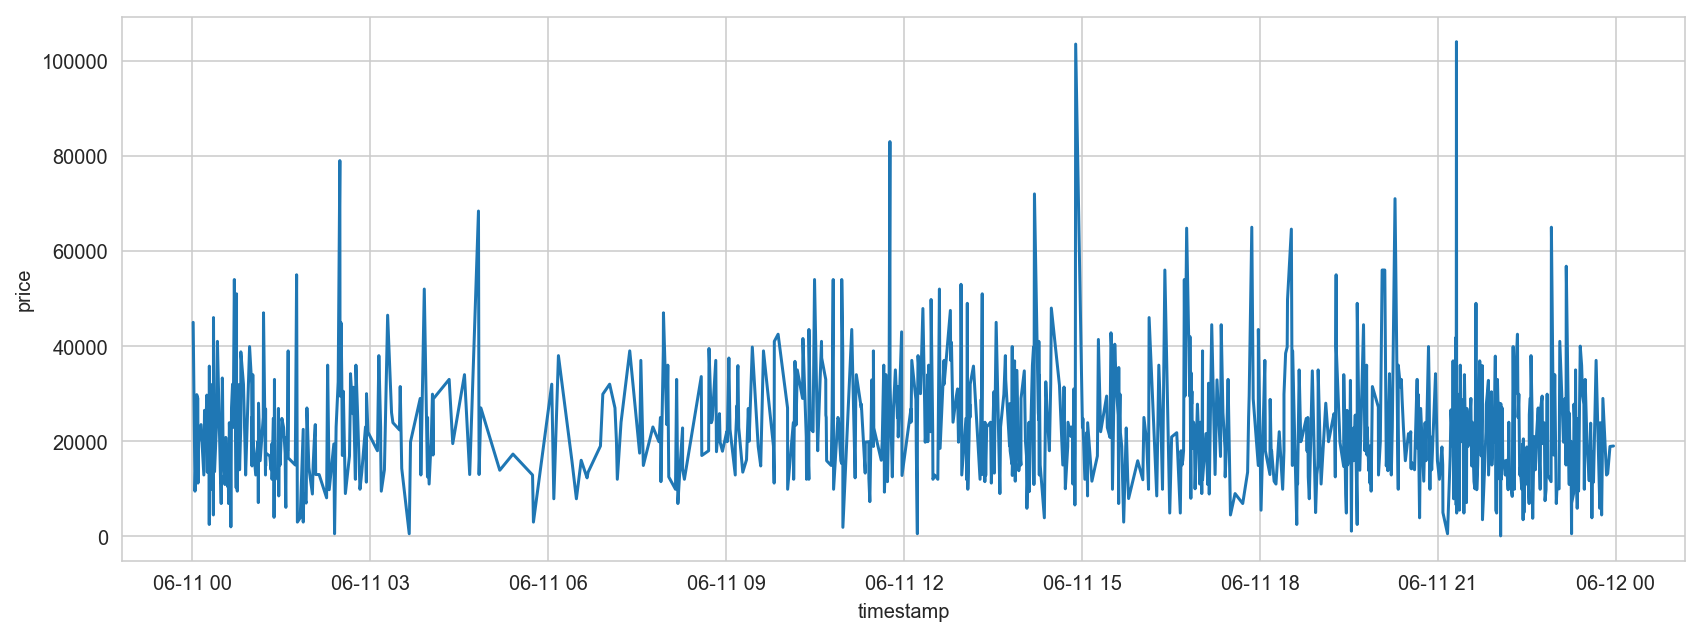

In [15]:
plt.figure(figsize = (14,5))
sns.lineplot(data = order, x = 'timestamp',y='price')

* 위의 그래프는 해석하기가 어렵기 때문에 binning이 필요해 보인다.
* 따라서 시간대별로 모두 합하는 binning 과정을 거친 후 시각화를 다시 해보자.

In [16]:
# 로그의 발생 시간을 나타내는 hour 컬럼을 추가하자
order['hour'] = order['timestamp'].dt.hour

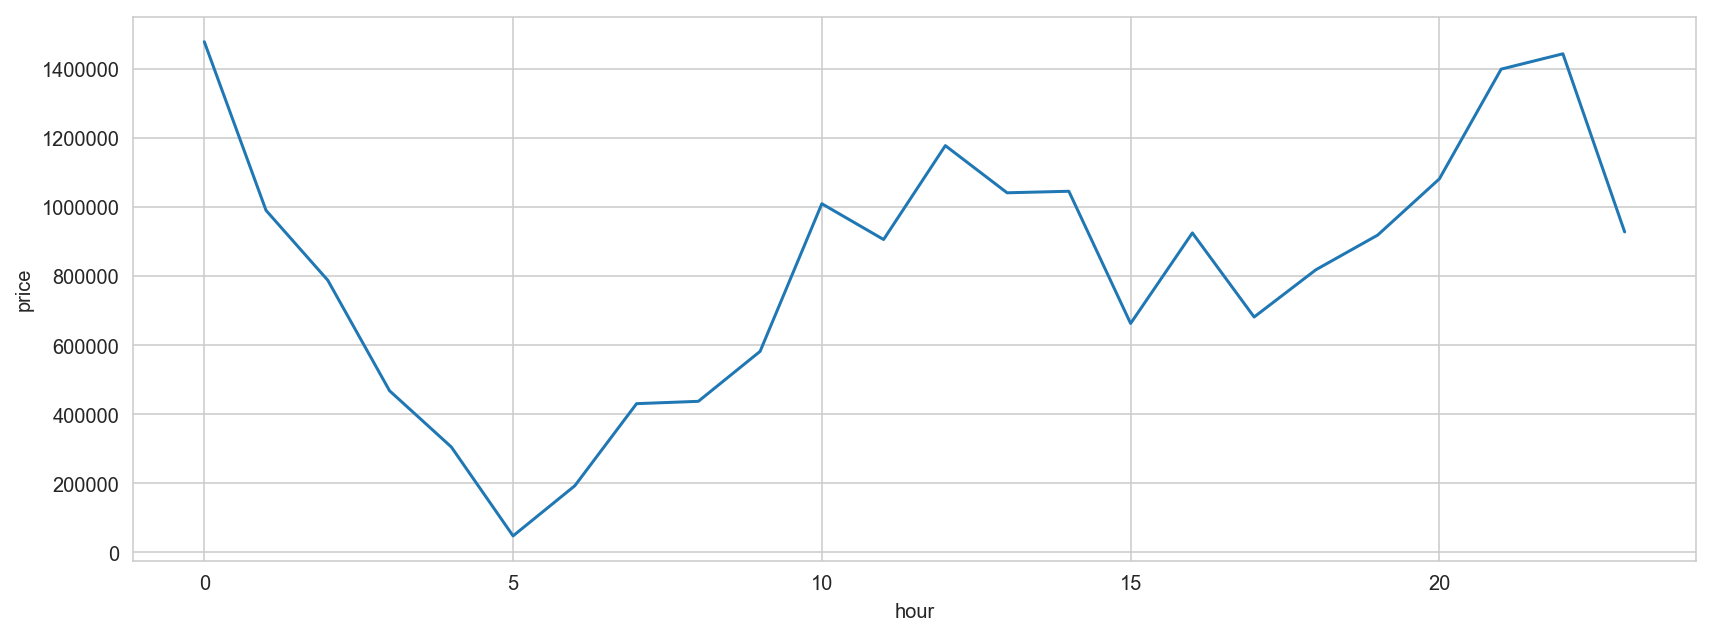

In [17]:
table = pd.pivot_table(data = order, 
              index = 'hour',
              values = 'price',
              aggfunc = sum)

plt.figure(figsize = (14,5))
sns.lineplot(data=table, x = table.index, y = 'price')

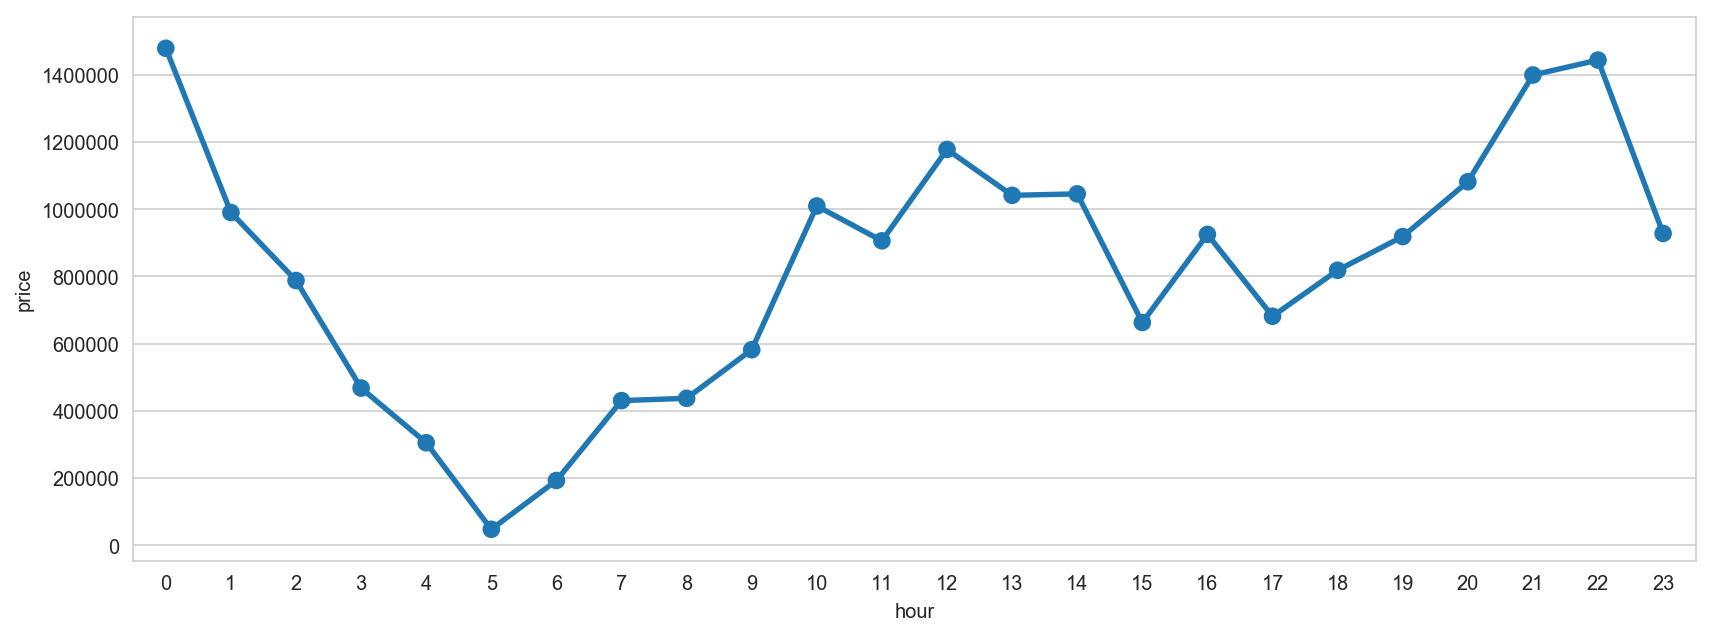

In [18]:
plt.figure(figsize = (14,5))
sns.pointplot(data = table, x = table.index , y ='price')

**4. user 테이블을 불러온 뒤 order 테이블과 병합하자.**

* user 테이블:
    * user_id: 고객의 고유 아이디
    * os: 접속 기기정보
    * age: 나이정보

In [19]:
query = "SELECT * FROM 'user'"
user = pd.read_sql(query, connect)
print(user.shape)
user.head()

(10000, 3)


,user_id,os,age
0,--PYPMX8QWg0ioT5zfORmU-S5Lln0lot,And,41
1,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,iOS,31
2,-1de9sT-MLwVVvnC0ncCLnqEqpSi3XSN,iOS,16
3,-3A3L2jnM55B_Q1bRXMjZ6sPnINIj-Y1,And,41
4,-3bhcSgPOIdQAPkPNcchxvECGqGQQ78k,And,42


In [20]:
merged = order.merge(user, on = 'user_id', how = 'left')
merged.head()

,timestamp,user_id,goods_id,shop_id,price,hour,os,age
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000,0,iOS,39
1,2018-06-11 00:02:33.763,smDmRnykg61KajpxXKzQ0oNkrh2nuSBj,1351,12,9500,0,And,17
2,2018-06-11 00:04:06.364,EyGjKYtSqZgqJ1ddKCtH5XwGirTyOH2P,646,14,22000,0,And,-1
3,2018-06-11 00:04:17.258,KQBGi33Zxh5Dgu0WEkOkjN0YqTT_wxC3,5901,46,29800,0,And,34
4,2018-06-11 00:05:26.010,lq1Je3voA3a0MouSFba3629lKCvweI24,5572,89,29000,0,And,17


**5. 매출 top10 쇼핑몰 구매자들의 연령대를 쇼핑몰별로 시각화하기**

In [21]:
#나이 정보가 없는 경우는 -1로 입력되어 있으므로 이를 NaN으로 처리하자
merged.loc[merged['age']== -1, 'age'] = np.nan

In [22]:
top10_table = merged.pivot_table(index='shop_id', values='price', 
                   aggfunc = sum).sort_values('price',ascending=False).head(10)
top10_table

,price
shop_id,
22,1365200
14,872000
63,710700
32,707900
126,669400
6,655900
11,653000
60,558300
19,518400


In [23]:
top10_name = top10_table.index
top10_data = merged[merged['shop_id'].isin(top10_name)]

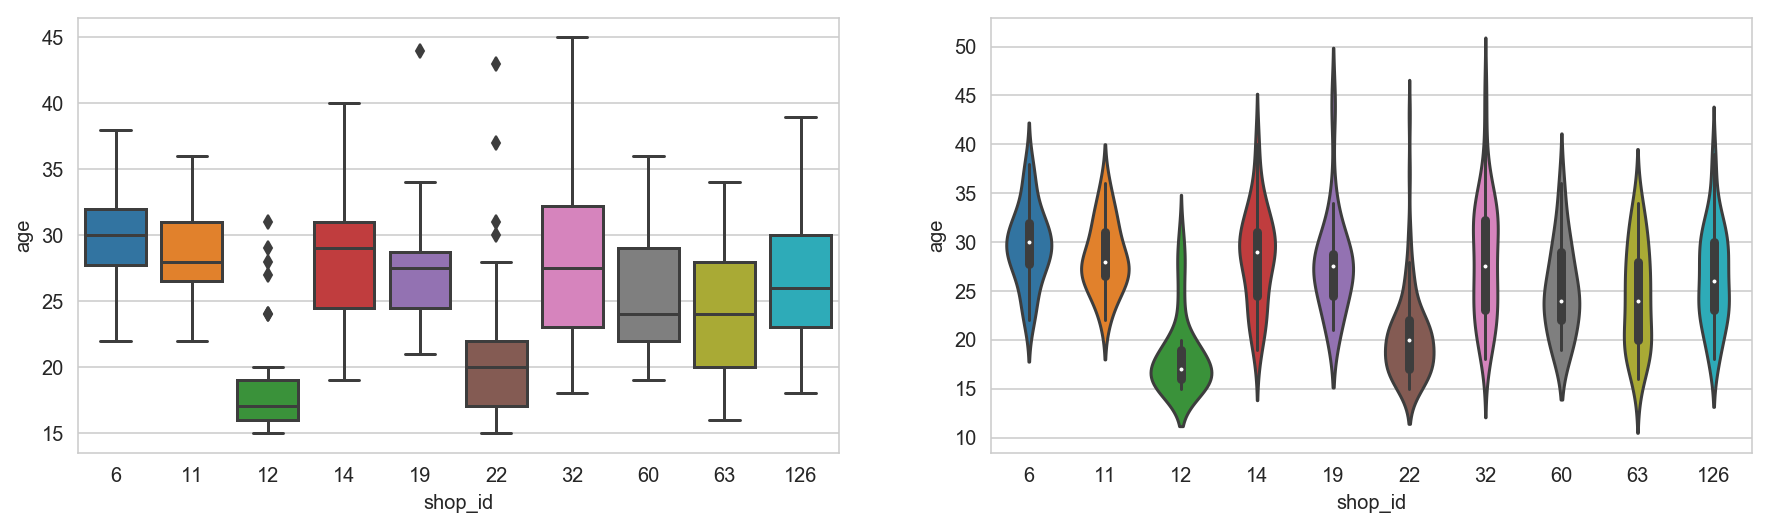

In [24]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches([15,4])

sns.boxplot(data = top10_data, x = 'shop_id', y = 'age', ax=ax1)
sns.violinplot(data = top10_data, x = 'shop_id', y = 'age', ax = ax2)

**6. user테이블에 연령대를 나타내는 컬럼 만들고, 쇼핑몰이 설정한 타겟 연령대와 실제 구매 연령대가 일치하는지 검증하기**

* 지그재그의 쇼핑몰들 연령대는 다음과 같이 나누어져있다.
img src="https://i.imgur.com/HMd9xC2.jpg" width=250

In [25]:
def age_band(age):
    if age == -1:
        return '미입력'
    elif age // 10 >=4:
        return '30대 후반'
    elif age // 10 == 1:
        return '10대'
    elif age % 10 <3:
        return str(age//10 * 10) + f"대 초반"
    elif age % 10 <=6:
        return str(age//10 * 10) + f'대 중반'
    elif age % 10 <=9:
        return str(age//10 * 10) + f'대 후반' 

In [26]:
user['연령대'] = user['age'].apply(age_band)

In [27]:
user.head()

,user_id,os,age,연령대
0,--PYPMX8QWg0ioT5zfORmU-S5Lln0lot,And,41,30대 후반
1,-16-xXbeDcvkZJtTpRwMi57Yo2ZQpORv,iOS,31,30대 초반
2,-1de9sT-MLwVVvnC0ncCLnqEqpSi3XSN,iOS,16,10대
3,-3A3L2jnM55B_Q1bRXMjZ6sPnINIj-Y1,And,41,30대 후반
4,-3bhcSgPOIdQAPkPNcchxvECGqGQQ78k,And,42,30대 후반


shop 테이블을 불러와 user, order 테이블과 병합하자.

In [28]:
query = "SELECT * FROM 'shop'"
shop = pd.read_sql(query,connect, index_col = 'shop_id')
print(shop.shape)
shop.head()

(200, 4)


,name,category,age,style
shop_id,,,,
1,Edna,의류,20대 중반/20대 후반/30대 초반,모던시크/러블리
2,Pam,의류,20대 중반/20대 후반/30대 초반,러블리/심플베이직
3,Carolyn,의류,20대 중반/20대 후반/30대 초반,모던시크/심플베이직
4,Joan,의류,30대 초반/30대 중반,미시스타일/유니크
5,Florene,의류,20대 중반/20대 후반/30대 초반,심플베이직/헐리웃스타일


In [29]:
merged_table = (
order.merge(user, on='user_id')
    .merge(shop, on='shop_id')
)

merged_table.head()

,timestamp,user_id,goods_id,shop_id,price,hour,os,age_x,연령대,name,category,age_y,style
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000,0,iOS,39,30대 후반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌
1,2018-06-11 07:33:39.823,ni3NQK35j-YaSxli-C_Sz7ZmQqOwMljL,2278,38,37000,7,And,32,30대 초반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌
2,2018-06-11 12:56:27.867,MnvhmV0tA89bN9TLXgRTbLza689bTkT9,5513,38,31000,12,And,37,30대 후반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌
3,2018-06-11 22:57:11.582,3Vo9NP0qU_176pgbqk6Cu-CY7kpJ2-WB,7026,38,17100,22,iOS,34,30대 중반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌
4,2018-06-11 00:02:33.763,smDmRnykg61KajpxXKzQ0oNkrh2nuSBj,1351,12,9500,0,And,17,10대,Rachel,의류,10대/20대 초반,러블리/심플베이직


In [30]:
def check_generation(row):
    if row['category'] == '의류' and row['연령대'] == '미입력':
        return True
    else:
        return row['연령대'] in str(row['age_y'])

In [31]:
merged_table['거래연령 일치여부'] = merged_table.apply(check_generation, axis=1)
merged_table.head(2)

,timestamp,user_id,goods_id,shop_id,price,hour,os,age_x,연령대,name,category,age_y,style,거래연령 일치여부
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000,0,iOS,39,30대 후반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌,False
1,2018-06-11 07:33:39.823,ni3NQK35j-YaSxli-C_Sz7ZmQqOwMljL,2278,38,37000,7,And,32,30대 초반,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌,True


In [32]:
table = merged_table.pivot_table(values='거래연령 일치여부',
                                                    index='shop_id',
                                                    aggfunc=['mean', 'count'])
table.head()

,mean,count
,거래연령 일치여부,거래연령 일치여부
shop_id,,
1,0.666667,3
2,0.937500,16
3,0.400000,5
4,1.000000,1
5,0.000000,1


In [33]:
table[table.index.isin(sum_top10)]

,mean,count
,거래연령 일치여부,거래연령 일치여부
shop_id,,
6,0.750000,24
12,0.857143,42
14,0.566667,30
19,0.789474,19
22,0.929293,99
28,0.650000,20
32,0.540541,37
60,0.695652,23


* 일치여부가 0이 나오는 것은 의류 이외의 제품을 파는 쇼핑몰은 타겟 연령층이 없기 때문으로 해석된다.

**7. 쇼핑몰의 스타일 태그 정리하기**

* 쇼핑몰별로 제품군의 스타일을 나타낼 수 있는 태그를 가지고 있다.

In [34]:
style_list = ['페미닌', '모던시크', '심플베이직', '러블리', '유니크', '미시스타일', '캠퍼스룩', '빈티지', '섹시글램', '스쿨룩', '로맨틱', '오피스룩',
              '럭셔리', '헐리웃스타일', '심플시크', '키치', '펑키', '큐티', '볼드&에스닉' ]

In [35]:
for style in style_list:
    shop[f'{style}'] = shop['style'].str.contains(style)

In [36]:
shop.head(3)

,name,category,age,style,페미닌,모던시크,심플베이직,러블리,유니크,미시스타일,캠퍼스룩,빈티지,섹시글램,스쿨룩,로맨틱,오피스룩,럭셔리,헐리웃스타일,심플시크,키치,펑키,큐티,볼드&에스닉
shop_id,,,,,,,,,,,,,,,,,,,,,,,
1,Edna,의류,20대 중반/20대 후반/30대 초반,모던시크/러블리,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Pam,의류,20대 중반/20대 후반/30대 초반,러블리/심플베이직,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Carolyn,의류,20대 중반/20대 후반/30대 초반,모던시크/심플베이직,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


**8. 스타일별 실제 구매 기록을 바탕으로 가장 구매가 많이 일어난 스타일 키워드를 찾자. 또한, 매출이 가장 많은 3가지 스타일의 구매 연령대 분포는?**

In [37]:
merged = (
    order.merge(shop, on = 'shop_id').merge(user, on = 'user_id'))

In [38]:
print(merged.shape)
merged.head(2)

(867, 32)


,timestamp,user_id,goods_id,shop_id,price,hour,name,category,age_x,style,페미닌,모던시크,심플베이직,러블리,유니크,미시스타일,캠퍼스룩,빈티지,섹시글램,스쿨룩,로맨틱,오피스룩,럭셔리,헐리웃스타일,심플시크,키치,펑키,큐티,볼드&에스닉,os,age_y,연령대
0,2018-06-11 00:00:43.032,bvu0aLTqiFDoU-963xnr5nzQWTNLUMjx,1414,38,45000,0,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,iOS,39,30대 후반
1,2018-06-11 07:33:39.823,ni3NQK35j-YaSxli-C_Sz7ZmQqOwMljL,2278,38,37000,7,Mabel,의류,20대 후반/30대 초반/30대 중반,모던시크/페미닌,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,And,32,30대 초반


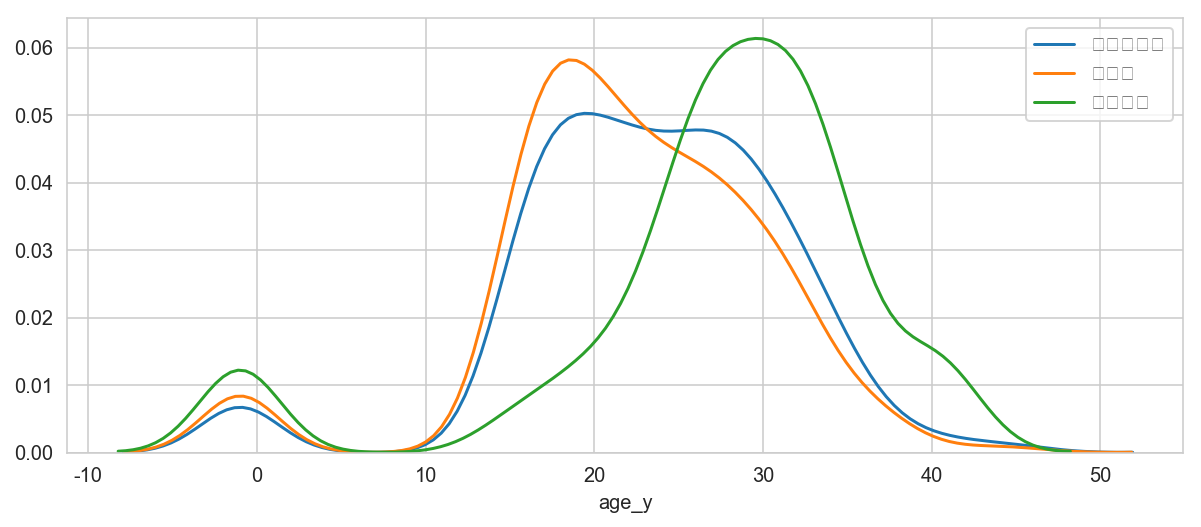

In [39]:
plt.figure(figsize=[10,4])

sns.distplot(merged.loc[merged['심플베이직'] == True, 'age_y'], label = '심플베이직', hist=False)
sns.distplot(merged.loc[merged['러블리'] == True, 'age_y'], label = '러블리', hist=False)
sns.distplot(merged.loc[merged['모던시크'] == True, 'age_y'], label = '모던시크', hist=False)

plt.savefig('dist.png', dpi=400)